<a href="https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/mAP_IoU_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mAP and IoU Evaluation Metrics

## Evaluating the quality of computer vision object detection models

- From [Understanding the mAP Evaluation Metric for Object Detection](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3) by [Timothy C Arlen](https://medium.com/@timothycarlen) on [medium.com](https://medium.com/)
- and From [Intersection over Union (IoU) for object detection](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) by [Adrian Rosebrock](https://www.pyimagesearch.com/author/adrian/) in [www.pyimagesearch.com](https://www.pyimagesearch.com/)
- and From [The Confusing Metrics of AP and mAP for Object Detection](https://mc.ai/the-confusing-metrics-of-ap-and-map-for-object-detection/) in [mc.ai](https://mc.ai)
 
Updated by [John Fogarty](https://github.com/jfogarty) for Python 3.6 and [Base2 MLI](https://github.com/base2solutions/mli) and [colab](https://colab.research.google.com) standalone evaluation.


<figure>
  <img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/waymo_panorama.gif?raw=1" width="100%" />
  <figcaption></figcaption>
</figure>

## Introduction

Instance segmentation is kind of a new field. Until the age of deep learning, there weren’t a who lot of datasets for it because the algorithms were simply not good enough. These days you mainly see [MSCOCO](http://cocodataset.org/#home), [PASCAL](http://host.robots.ox.ac.uk/pascal/VOC/), [CityScape](https://www.cityscapes-dataset.com/), and all sorts of datasets that include a task called instance segmentation. The main idea of instance segmentation is that we have to segment out each instance of each category, so that, for example, two people in an image will have the same category label as “person” but different instance labels like “person 1” and “person 2”, as shown below.


<figure>
  <img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/map_image_segmentation.png?raw=1" width="80%" />
  <figcaption></figcaption>
</figure>

### Precision and Recall

To evaluate a certain algorithm on instance segmentation, usually you will see the terms mentioned above, namely AP (Average Precision) and mAP (Mean Average Precision).

Let’s start with the definition of **precision** and **recall**.

$$
    Precision = \frac{tp}{tp + fp}
$$

$$
    Recall = \frac{tp}{tp + fn}
$$

where tp = true positive, fp = false positive, fn = false negative. What are they? 

The table below should make things clear:

<figure>
  <img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/map_truths.png?raw=1" width="60%" />
  <figcaption></figcaption>
</figure>

So basically precision is measuring the percentage of correct positive predictions among all positive cases in reality; and recall is measuring the percentage of correct positive predictions among all predictions made. There is always a trade-off between the two metrics. Imagine if we label everything as positive, then recall will be 1 because we do not have false negatives, but precision will be horrible because only a small percentage of our positive predictions are actually correct. In the other extreme case, we can be very careful about the selection of positive prediction, so prediction will be very good, but we might have labelled many positive cases as negative and consequently lowered recall.

## IoU - Intersection Over Union

Now that we understand precision and recall, we are well equipped to understand average precision. It is defined as the area under the precision-recall curve (PR curve). The x-axis is recall, and y-axis is precision. How do we get multiple precision-recall value pairs? In the case of objection detection or instance segmentation, this is done by changing the IoU threshold. First we have to understand what IoU (Intersection over Union) is. The image below is my favorite explanation.

<figure>
  <img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/IoU.png?raw=1" width="50%" />
  <figcaption></figcaption>
</figure>

Below I have included a visual example of a ground-truth bounding box versus a predicted bounding box:

<figure><center>
  <img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/IoU2.png?raw=1" width="50%" />
  <figcaption></figcaption></center>
</figure>

Intersection over Union is simply an evaluation metric. Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.

More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:

1. The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).


2. The predicted bounding boxes from our model.

As long as we have these two sets of bounding boxes we can apply Intersection over Union

## mAP : Mean Average Precision

If you’ve evaluated models in object detection or you’ve read papers in this area, you may have encountered the mean average precision or “mAP score” (for example [here](https://arxiv.org/abs/1512.03385) or [here](https://arxiv.org/abs/1703.06870) or [here](https://arxiv.org/abs/1506.01497)).

It has become the accepted way to evaluate object detection competitions, such as for the [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/), [ImageNet](http://image-net.org/), and [COCO](http://cocodataset.org/#home) challenges. In this article, I will explain:

- what the mean average precision (mAP) metric is,

- why it is a useful metric in object detection,

- how to calculate it with example data for a particular class of object.

Additionally, I will provide some code (link at the end of the article) to compute this metric for use in your own projects or work if desired.

## Evaluating Object Detectors

In object detection, evaluation is non trivial, because there are two distinct tasks to measure:

1. Determining whether an object exists in the image (classification)

2. Determining the location of the object (localization, a regression task).

Furthermore, in a typical data set there will be many classes and their distribution is non-uniform (for example there might be many more dogs than ice cream cones). So a simple accuracy-based metric will introduce biases. It is also important to assess the risk of misclassifications. Thus, there is the need to associate a “confidence score” or **model score** with each bounding box detected and to assess the model at various level of confidence.

In order to address these needs, the Average Precision (AP) was introduced. To understand the AP, it is necessary to understand the precision and recall of a classifier. For a more comprehensive explanation of these terms, the [wikipedia article](https://en.wikipedia.org/wiki/Precision_and_recall) is a nice place to start.

Briefly, in this context:

> ***Precision measures the “false positive rate” or the ratio of true object detections to the total number of objects that the classifier predicted.***

If you have a precision score of close to 1.0 then there is a high likelihood that whatever the classifier predicts as a positive detection is in fact a correct prediction. 

> ***Recall measures the “false negative rate” or the ratio of true object detections to the total number of objects in the data set.***

If you have a recall score close to 1.0 then almost all objects that are in your dataset will be positively detected by the model. Finally, it is very important to note that the there is an inverse relationship between precision and recall and that *these metrics are dependent on the model score threshold that you set* (as well as of course, the quality of the model). For example, in [this image](https://github.com/tensorflow/models/tree/master/research/object_detection#tensorflow-object-detection-api) from the TensorFlow Object Detection API, if we set the model score threshold at 50 % for the “kite” object, we get 7 positive class detections, but if we set our model score threshold at 90 %, there are 4 positive class detections.

To calculate the AP, for a specific class (say a “person”) the precision-recall curve is computed from the model’s detection output, by varying the model score threshold that determines what is counted as a model-predicted positive detection of the class. An example precision-recall curve may look something like this for a given classifier:

<figure>
  <img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/map_pr_curve.png?raw=1" />
  <figcaption>Precision-Recall curve for an example classifier. A point on the precision-recall curve is determined by considering all objects above a given model score threshold as a positive prediction, then calculating the resulting precision and recall for that threshold.</figcaption>
</figure>

The final step to calculating the AP score is to take the average value of the precision across all recall values (see explanation in section 4.2 of the [Pascal Challenge paper pdf](http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf) which I outline here). This becomes the single value summarizing the shape of the precision-recall curve. To do this unambiguously, the AP score is defined as the mean precision at the set of 11 equally spaced recall values, $Recall_i = [0, 0.1, 0.2, …, 1.0]$. Thus,

$$
  AP = \frac{1}{11} \sum_{Recall_i} Precision(Recall_i)
$$

The precision at $Recall_i$ is taken to be the maximum precision measured at a recall exceeding $Recall_i$.
Up until now, we have been discussing only the classification task. For the localization component (was the object’s location correctly predicted?) we must consider the amount of overlap between the part of the image segmented as true by the model vs. that part of the image where the object is actually located.

## Localization and Intersection over Union

In order to evaluate the model on the task of object localization, we must first determine how well the model predicted the location of the object. Usually, this is done by drawing a bounding box around the object of interest, but in some cases it is an N-sided polygon or even pixel by pixel segmentation. For all of these cases, the localization task is typically evaluated on the Intersection over Union threshold (IoU). For definiteness, throughout the rest of the article, I’ll assume that the model predicts bounding boxes, but almost everything said will also apply to pixel-wise segmentation or N-sided polygons. Many good explanations of IoU exist, (see this one for example), but the basic idea is that it summarizes how well the ground truth object overlaps the object boundary predicted by the model.

Model object detections are determined to be true or false depending upon the IoU threshold. This IoU threshold(s) for each competition vary, but in the [COCO challenge](http://cocodataset.org/#detections-eval), for example, 10 different IoU thresholds are considered, from 0.5 to 0.95 in steps of 0.05. For a specific object (say, ‘person’) this is what the precision-recall curves may look like when calculated at the different IoU thresholds of the COCO challenge:

<figure>
  <img src="https://github.com/jfogarty/machine-learning-intro-workshop/blob/master/images/map_pr_curve_person.png?raw=1" />
  <figcaption>Precision-Recall curves calculated at various IoU thresholds, according to the COCO challenge. Dashed lines correspond to equally spaced recall values where the AP is calculated.</figcaption>
</figure>


### Putting it all together

Now that we’ve defined Average Precision (AP) and seen how the IoU threshold affects it, the **mean Average Precision or mAP score is calculated by taking the mean AP over all classes and/or over all IoU thresholds**, depending on the competition. For example:

- PASCAL VOC2007 challenge only 1 IoU threshold was considered: 0.5 so the mAP was averaged over all 20 object classes.


- For the COCO 2017 challenge, the mAP was averaged over all 80 object categories and all 10 IoU thresholds.

> ***Averaging over the 10 IoU thresholds rather than only considering one generous threshold of IoU ≥ 0.5 tends to reward models that are better at precise localization.***

## Get some data to test the mAP calculator

In [1]:
import os
URL='https://raw.githubusercontent.com/jfogarty/machine-learning-intro-workshop/master/data/mAP/ground_truth_boxes.json'
filename = 'ground_truth_boxes.json'
TMPDATA  = './tmpData'
if not os.path.exists(TMPDATA) : os.makedirs(TMPDATA)
ground_truth_filepath = os.path.join(TMPDATA, filename)
!curl $URL -o $ground_truth_filepath

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20703  100 20703    0     0   3627      0  0:00:05  0:00:05 --:--:--  4933


In [3]:
import os
URL='https://raw.githubusercontent.com/jfogarty/machine-learning-intro-workshop/master/data/mAP/predicted_boxes.json'
filename = 'predicted_boxes.json'
TMPDATA  = './tmpData'
if not os.path.exists(TMPDATA) : os.makedirs(TMPDATA)
predicted_filepath = os.path.join(TMPDATA, filename)
!curl $URL -o $predicted_filepath

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  110k  100  110k    0     0  1577k      0 --:--:-- --:--:-- --:--:-- 1577k


## Code for Calculating the mean Average Precision

### Tim Arlen's mAP calculator

I found the code for calculating the mean Average Precision in the COCO dataset a bit opaque and perhaps not well-optimized. So I created my own set of functions to perform the calculation without relying on the coco API(for bounding boxes only at this time). The code takes ground truth boxes in the format of a dictionary of lists of boxes:

```
    {"filename1": [[xmin, ymin, xmax, ymax],...,[xmin, ymin, xmax, ymax]],
    "filename2": [...],
    ...
    }
```

and predicted boxes as a dictionary of a dictionary of boxes and scores like this:

```
    {'filename1': {
      'boxes': [[xmin, ymin, xmax, ymax],...,[xmin, ymin, xmax, ymax]],
      'scores': [score1,...,scoreN]},
     'filename2': {
       'boxes': [[xmin, ymin, xmax, ymax],...,[xmin, ymin, xmax, ymax]],
       'scores': [score1,...,scoreN]},
    ...
    }
```

For the example I was working with, I had a total of 656 ground truth boxes to evaluate for one category (person) and a total number of 4854 predicted boxes for the same category (person), and it takes me a total of ~0.45 seconds to calculate the AP at 1 IoU threshold for 1 class (running on my laptop with 16 GB or RAM and a 3.1 GHz Intel Core processor). See [the code on github](https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734) for details, and thanks for reading!



In [0]:
%matplotlib inline

In [0]:
"""
author: Timothy C. Arlen
date: 28 Feb 2018

Calculate Mean Average Precision (mAP) for a set of bounding boxes corresponding to specific
image Ids. Usage:

> python calculate_mean_ap.py

Will display a plot of precision vs recall curves at 10 distinct IoU thresholds as well as output
summary information regarding the average precision and mAP scores.

NOTE: Requires the files `ground_truth_boxes.json` and `predicted_boxes.json` which can be
downloaded fromt this gist.
"""

from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

In [0]:
def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box

    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]

    Returns:
        float: value of the IoU for the two boxes.

    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

In [0]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

In [0]:
def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images

    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }

    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

In [0]:
def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [0]:
def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [0]:
def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax

Single IoU calculation took 0.5284 secs
avg precision: 0.7804
map: 56.38
avg precs:  [0.9068, 0.9057, 0.9028, 0.8895, 0.7804, 0.5894, 0.39, 0.221, 0.0431, 0.0091]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 5.7666 secs


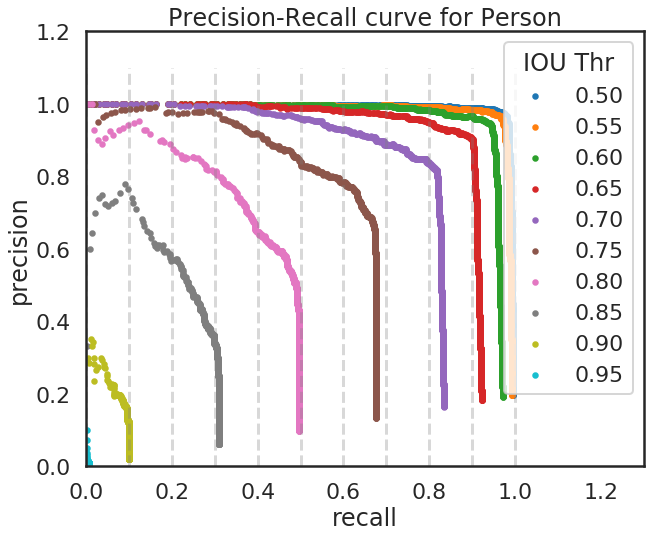

In [12]:
if __name__ == "__main__":

    with open(ground_truth_filepath) as infile:
        gt_boxes = json.load(infile)

    with open(predicted_filepath) as infile:
        pred_boxes = json.load(infile)

    # Runs it for one IoU threshold
    iou_thr = 0.7
    start_time = time.time()
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    end_time = time.time()
    print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
    print('avg precision: {:.4f}'.format(data['avg_prec']))

    start_time = time.time()
    ax = None
    avg_precs = []
    iou_thrs = []
    for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
        data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']
        ax = plot_pr_curve(
            precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    print('map: {:.2f}'.format(100*np.mean(avg_precs)))
    print('avg precs: ', avg_precs)
    print('iou_thrs:  ', iou_thrs)
    plt.legend(loc='upper right', title='IOU Thr', frameon=True)
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
    end_time = time.time()
    print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
    plt.show()

### End of notebook.